In [13]:
# Importing the necessary libraries
import numpy as np
from numpy import pi
from scipy.linalg import expm, sinm, cosm, sqrtm
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import *
from qiskit.circuit.library.standard_gates import XGate, MCXGate
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.tools.jupyter import *
from qiskit.visualization import *

## QSVT

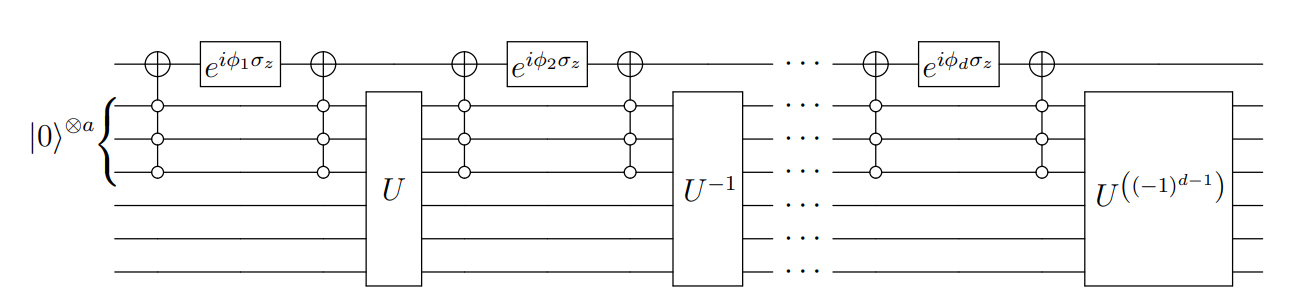

In [76]:
def QSVT(phi_vec, n, U):
    nqubits = 2*n+1
    q = QuantumRegister(nqubits, 'q')
    circuit = QuantumCircuit(q)

    for k in range(1, nqubits):
        circuit.h(k)

    # calculate anti-toffoli gate
    anti_gate  = MCXGate(n, ctrl_state='0'*n)
    target_list = [q[i] for i in range(1, n+1)]
    target_list.append(q[0])

    circuit.append(anti_gate , target_list)
    circuit.rz(-2*phi_vec[0], q[0])
    circuit.append(anti_gate , target_list)

    circuit.append(U, [q[i] for i in range(1, nqubits)])

    for k in range(1, len(phi_vec)):
        

        circuit.append(anti_gate , target_list)
        circuit.rz(-2*phi_vec[k], q[0])
        circuit.append(anti_gate , target_list)

        circuit.append(U, [q[i] for i in range(1, nqubits)])
    circuit.measure_all()
    return circuit

#### Search by QSVT

##### Calculating the phase angles

[pyqsp.poly.PolySign] degree=19, delta=10
[PolyTaylorSeries] max [0.89971468] is at [0.99483859]: normalizing
[PolyTaylorSeries] average error = 0.10201669723318954 in the domain [-1, 1] using degree 19


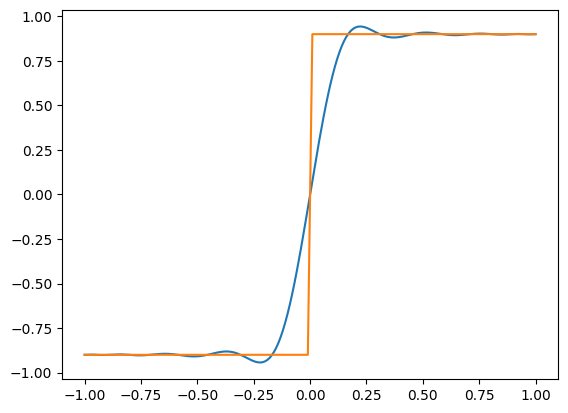

In [77]:
import pyqsp

pg = pyqsp.poly.PolySign()
pcoeffs, scale = pg.generate(degree=19, delta=10, ensure_bounded=True, return_scale=True)
poly_filt = np.polynomial.Polynomial(pcoeffs)
poly_filt.degree()

a_list = np.linspace(-1, 1, 201)
plt.plot(a_list, poly_filt(a_list), label="polynomial")

def target_filt(x, delta, scale=1):
    """
    Target function for sign function.
    """
    return scale * (np.sign(x - 0))

plt.plot(a_list, target_filt(a_list, 0.3, scale=0.9), label="target function")

In [78]:
def U(q): 
    qc = QuantumCircuit(q)
    n = q + 1
    
    qc = QuantumCircuit(q)
    n = q + 1
        
    for qubit in range(1, n-1):
        qc.x(qubit)
        
    qc.mcx(list(range(1,n-1)), 0)

    for qubit in range(1, n-1):
        qc.x(qubit)
    
    U_gate = qc.to_gate()
    U_gate.name = "U"
    return U_gate

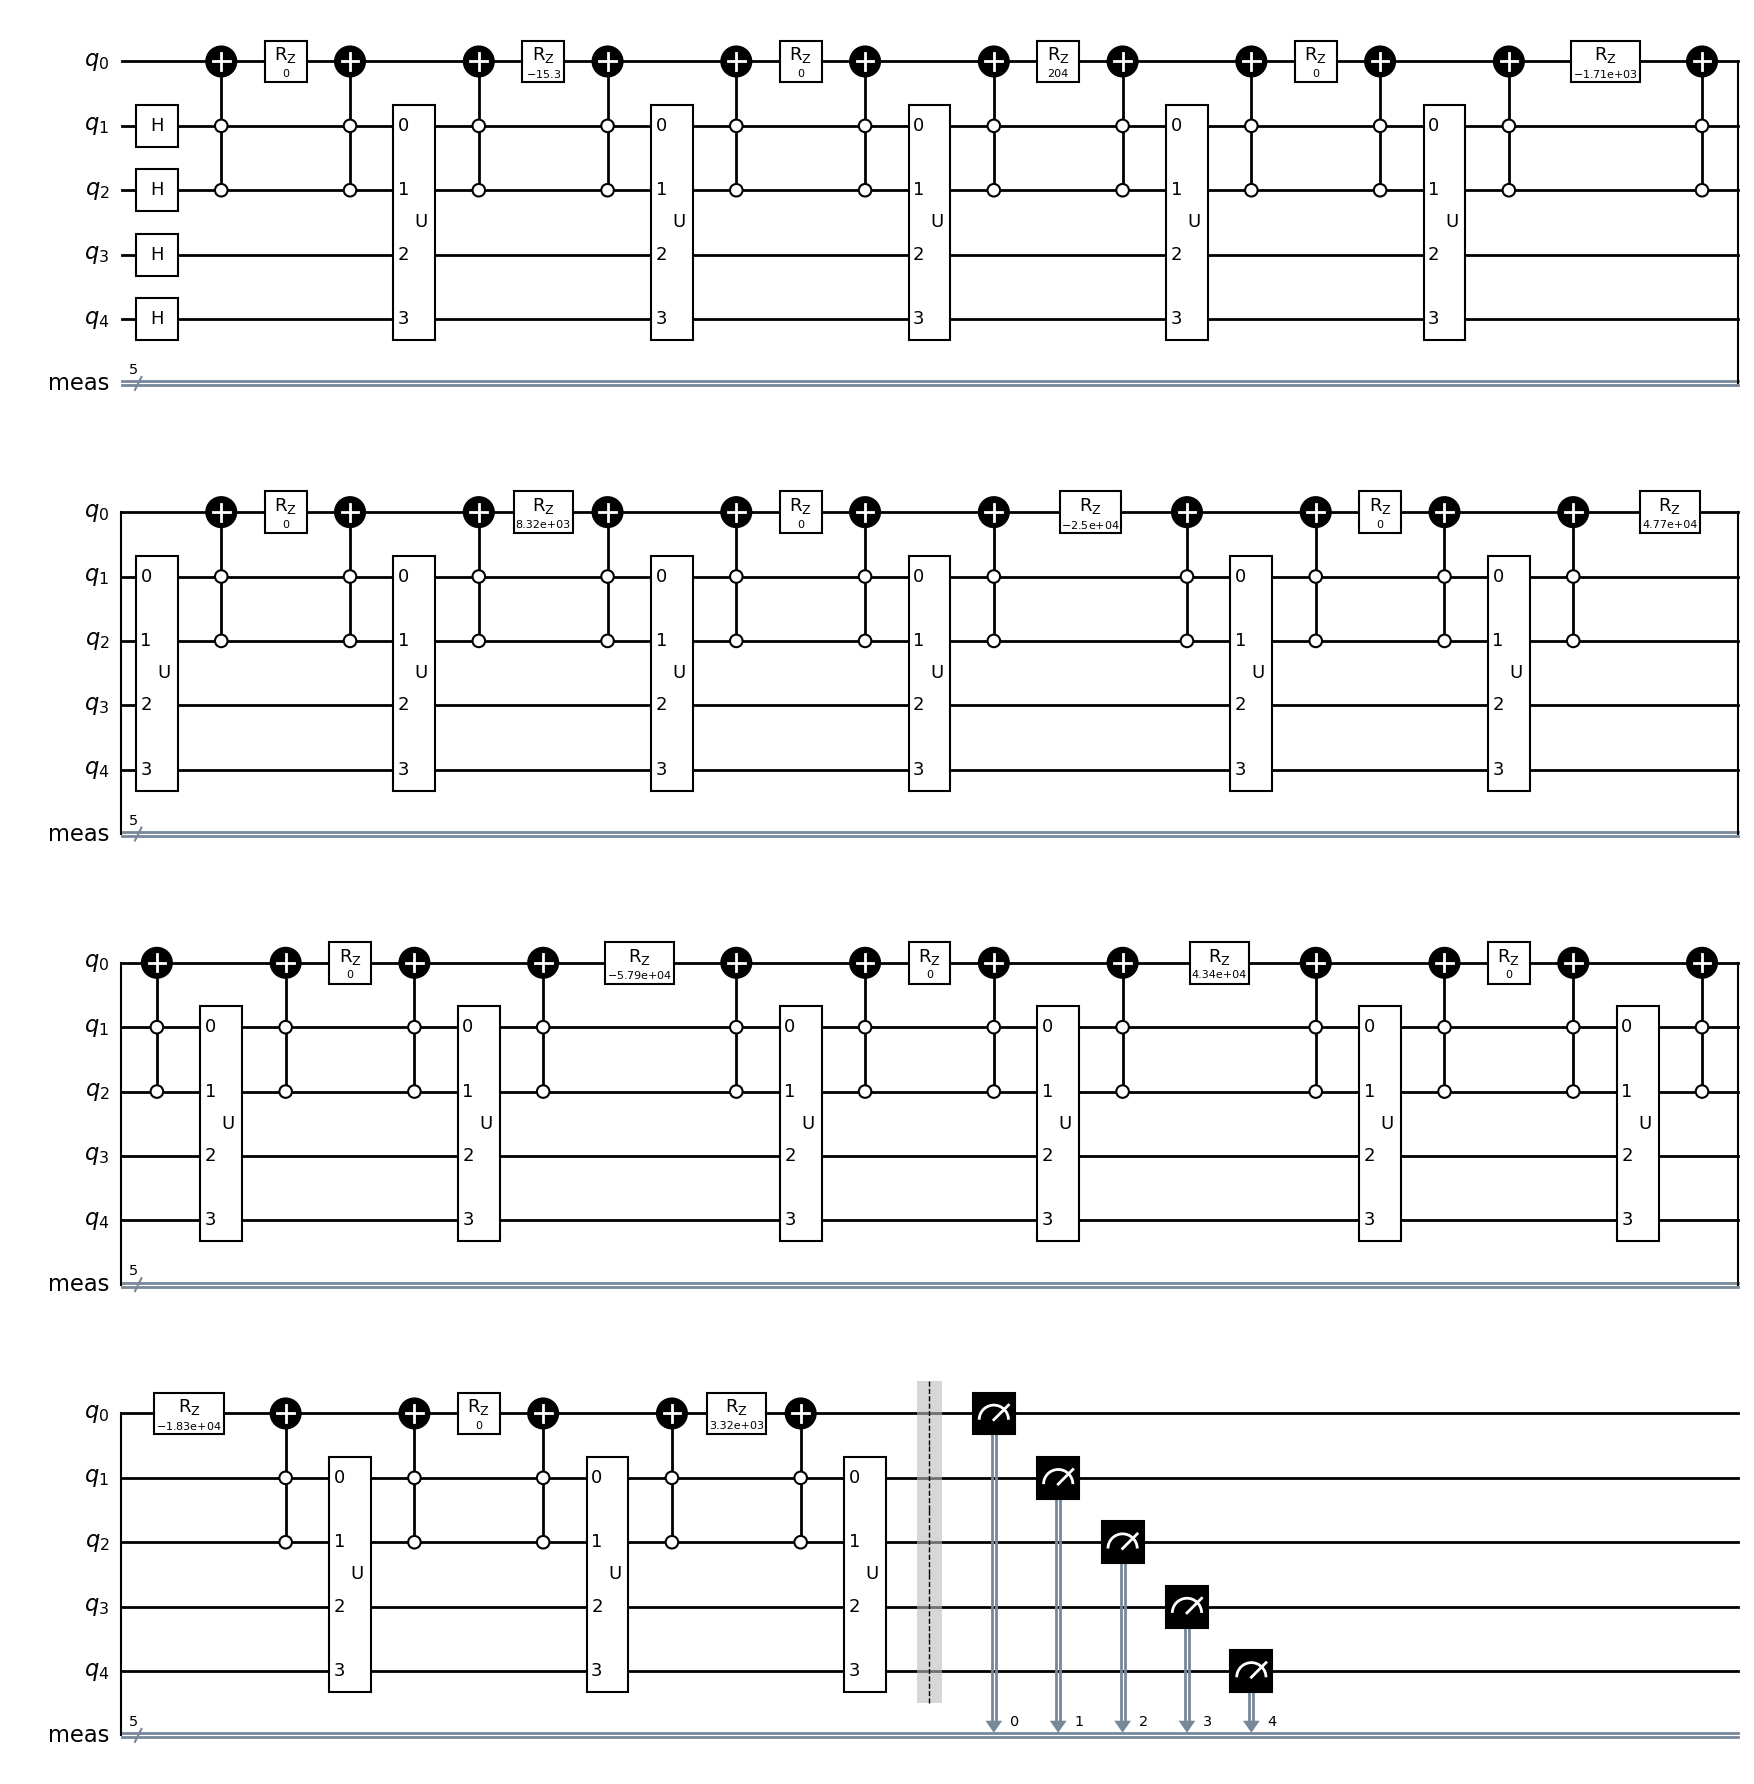

In [79]:
qc = QSVT(pcoeffs, 2, U(4))
qc.draw('mpl', style="bw")

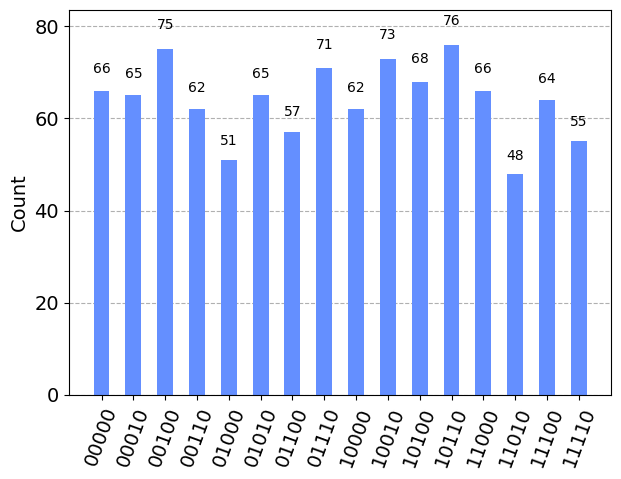

In [85]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(qc, qasm_sim)
qobj = assemble(transpiled_circuit)
results = qasm_sim.run(transpiled_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

### Controlled QEVT

In [64]:
X_gate = np.array([[0, 1], [1, 0]], dtype = 'complex_')
Y_gate = np.array([[0, -1j], [1j, 0]], dtype = 'complex_')
Z_gate = np.array([[1, 0], [0, -1]], dtype = 'complex_')

H = X_gate @ X_gate @ Y_gate @ Z_gate + X_gate @ Y_gate @ Z_gate + Y_gate @ Z_gate + Z_gate @ X_gate



def U(H):
    matrix = np.kron(Z_gate, H) + np.kron(X_gate, np.sqrt(np.eye(2) - sqrtm(H)))
    print(matrix)
    gate = UnitaryGate(matrix)
    return gate

In [ ]:
def C_QSVT(phi_vec, n, U):
    nqubits = 2*n+1
    q = QuantumRegister(nqubits, 'q')
    circuit = QuantumCircuit(q)

    # calculate anti-toffoli gate
    anti_gate  = MCXGate(n, ctrl_state='0'*n)
    target_list = [q[i+1] for i in range(1, n+1)]
    target_list.append(q[1])

    # create controlled Z-rotation gate
    qc1 = QuantumCircuit(1, name="$e^{-i\phi Z}$")
    qc1.rz(-2*phi_vec[0], 0)
    c_rz = qc1.to_gate().control(1)
    anti_c_rz = qc1.to_gate().control(1, ctrl_state='0')

    circuit.append(anti_gate , target_list)
    circuit.append(anti_c_rz, [0, 1])
    circuit.append(U, [2,3,4])
    circuit.append(c_rz, [0, 1])
    circuit.append(anti_gate , target_list)

    for k in range(1, len(phi_vec)):
        

        circuit.append(anti_gate , target_list)
        circuit.append(anti_c_rz, [0, 1])

        circuit.append(U, [2,3,4])

        circuit.append(c_rz, [0, 1])
        circuit.append(anti_gate , target_list)
    circuit.measure_all()
    return circuit